# Computer vision - Week_04 - Textures

In [117]:
import numpy as np, matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.color import label2rgb
from skimage.filters.rank import entropy
from skimage import color, io, morphology, filters
from skimage.feature import greycomatrix, greycoprops
from skimage.segmentation import find_boundaries, mark_boundaries

The surface of many objects has a characteristic pattern, the so-called texture. Textures can have different visual properties and we intuitively evaluate them as "soft", "rough", "regular", "expressive" and so on. When recognizing textures (segmentation based on information), it is not possible to assess individual points of the image, as we did in the case of segmentation based on brightness, etc. colors. It is to put the body of the image in relation with their surroundings. Using texture information, it is possible to segment objects that may not be distinguishable based on other criteria.

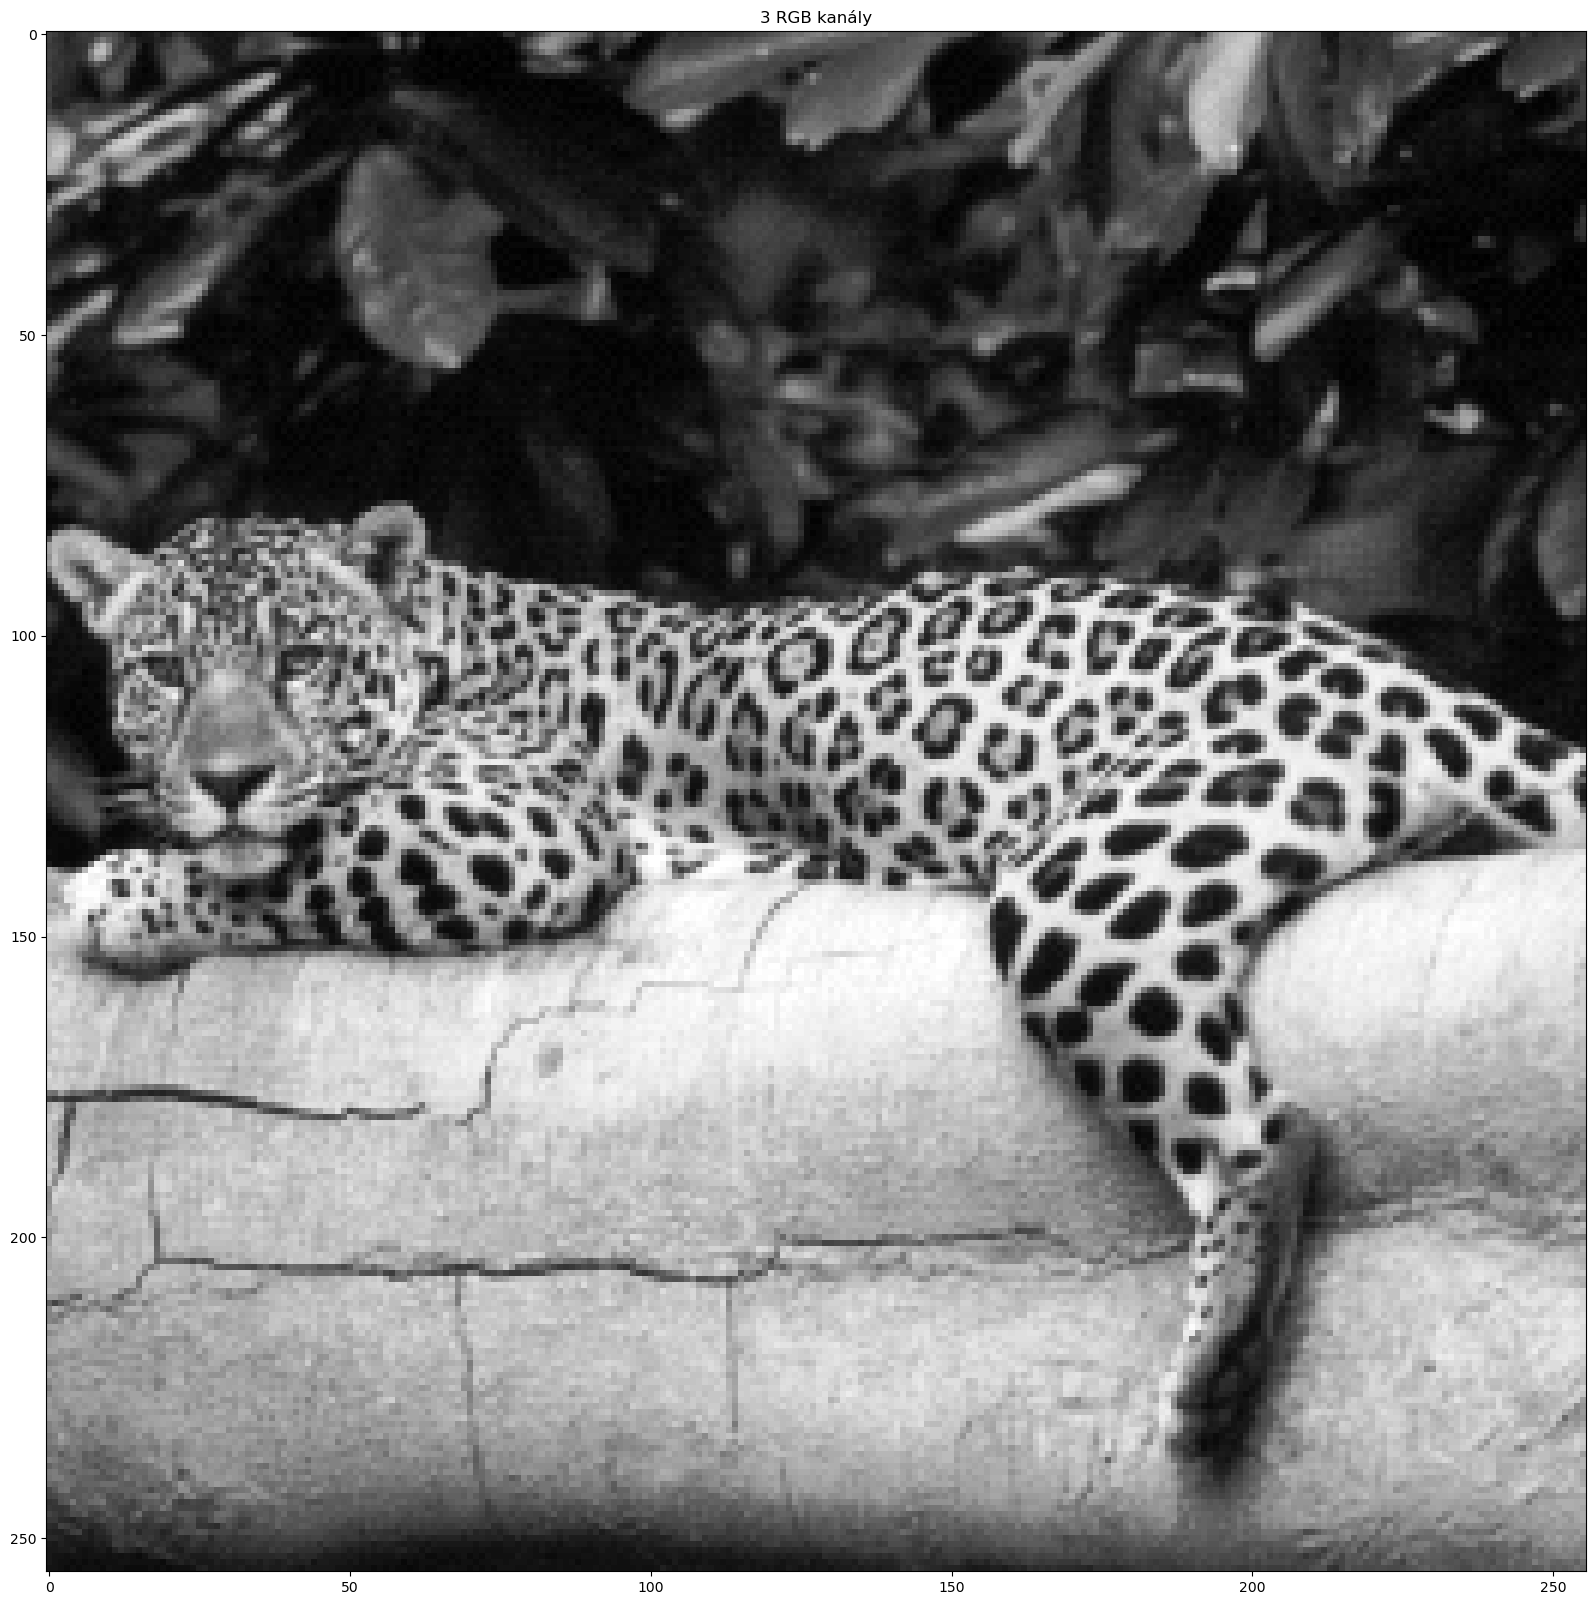

In [118]:
img = io.imread('_data/jaguar.gif')
img = (color.rgb2gray(img[..., 0:3])*255).astype(np.uint8)
plt.figure(figsize= (20, 20))
plt.title('3 RGB kanály')
plt.imshow(img, cmap="gray")

## Entropy, contrast, correlation, energy, homogeneity
Based on the subjective impression, we could say that there are three basic textures in the image, the texture of the jaguar, the background leaves and the tree trunk. In order to segment the image algorithmically, we need to find quantifiable properties that would describe the textures. We will consider small sections of the original image. One of the attributes describing textures is entropy, which reflects the degree of randomness in the texture. We calculate the entropy for each pixel based on its brightness and the brightness of the pixels around it using the entropy function.

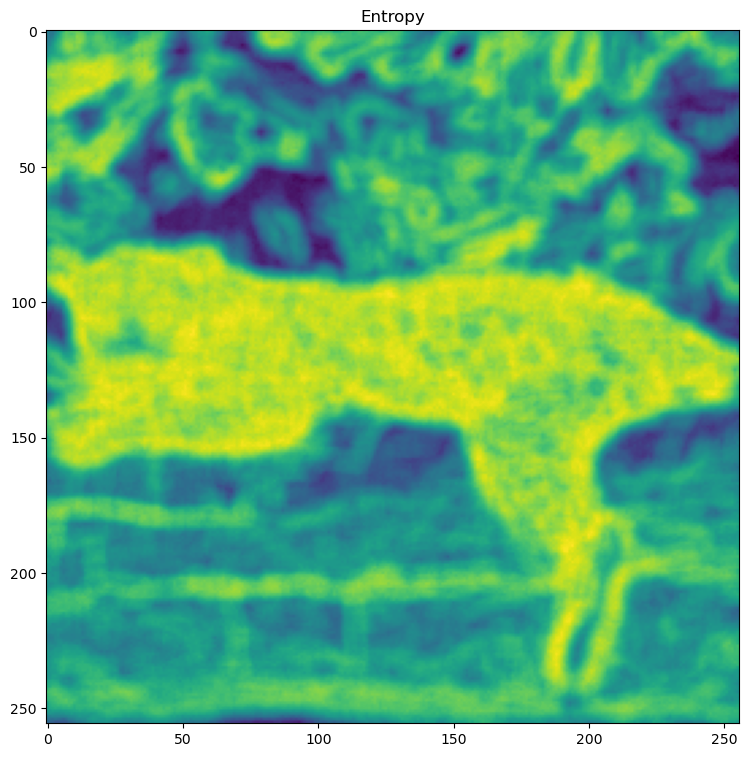

In [119]:
plt.figure(figsize= (9, 9))
plt.title('Entropy')
im_entropy = entropy(img, morphology.disk(5))
plt.imshow(im_entropy)

It is clear from the image that the entropy distinguishes the jaguar texture from the rest of the image quite well. However, there are many other texture attributes. We will now calculate some of them for the same neighborhood as above, namely:

- **Contrast**, the difference between the brightness intensities of a pixel and its neighbors in the entire viewport. Contrast is zero for a constant image.
- **Correlation**, a statistical measure of the dependence of the brightness value of a pixel on the brightness values of its neighbors.
- **Energy** determines the degree of orderliness of the image.
- **Homogeneity**, a quality determining the degree of similarity of different image areas.

The spacing of examined pixels, if not defined otherwise, is 0 rows and 1 column, i.e. the scaled brightness values of neighboring pixels in the horizontal direction are examined. We initialize these zero matrices with the dimension of the im_entropy array.

Now we will cycle through all the slices of the image. For each section, we calculate the cocurrence matrix and the values of the monitored properties. We write these into the corresponding matrices.

In [ ]:
# Extract a window from the grayscale image, where the size of the window is defined by window_size.
# Calculate the Gray-Level Co-occurrence Matrix (GLCM) for the window using greycomatrix from scikit-image.
# Calculate the specified texture properties (contrast, correlation, energy, homogeneity) from the GLCM using greycoprops.
# Store the calculated texture properties in the corresponding matrices (im_contrast, im_correlation, im_energy, im_homogeneity) at the appropriate location.
# The resulting matrices now contain the texture properties for different sections of the image, which you can use for further analysis or visualization.
# Ignore all warnings
import warnings
# Ignore DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning, module='skimage')

# Define the parameters for texture analysis
distances = [1]
angles = [0]
properties = ['contrast', 'correlation', 'energy', 'homogeneity']
window_size = 9

# Initialize matrices to store texture properties
im_contrast = np.zeros_like(im_entropy)
im_correlation = np.zeros_like(im_entropy)
im_energy = np.zeros_like(im_entropy)
im_homogeneity = np.zeros_like(im_entropy)

# Iterate through image slices to calculate texture properties
for i in tqdm(range(0, im_entropy.shape[0] - window_size)):
    for j in range(0, im_entropy.shape[1] - window_size):

        # Extract a window from the grayscale image
        window = img[i:i + window_size, j:j + window_size]

        # Calculate the gray-level co-occurrence matrix (GLCM) for the window
        glcm = greycomatrix(window,
                            distances=distances,
                            angles=angles,
                            symmetric=True,
                            normed=True)

        # Calculate and store texture properties in the corresponding matrices
        feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
        im_contrast[i, j] = feats[0]
        im_correlation[i, j] = feats[1]
        im_energy[i, j] = feats[2]
        im_homogeneity[i, j] = feats[3]

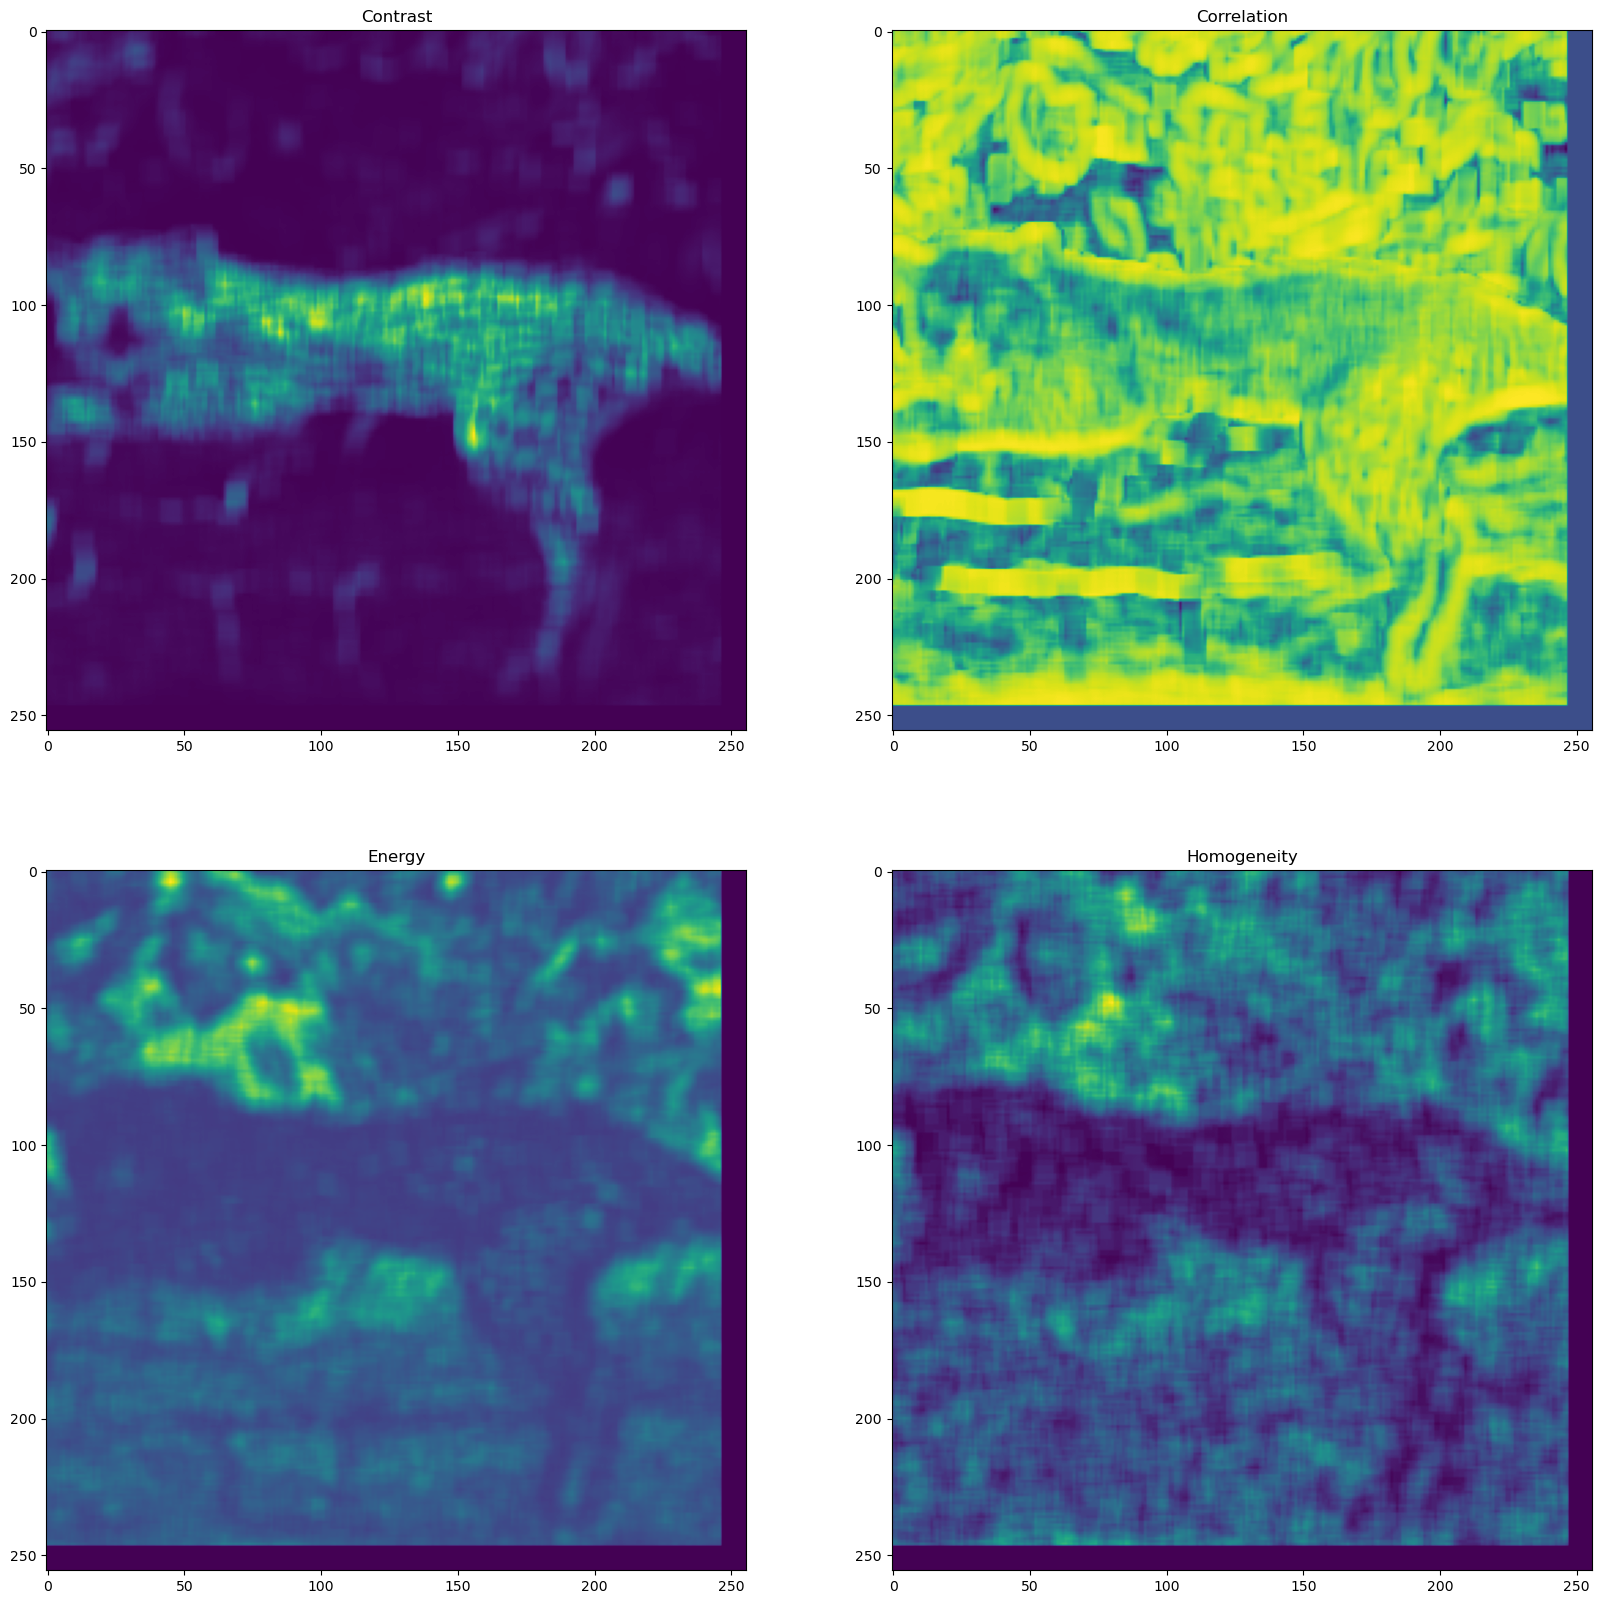

In [121]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Contrast')
plt.imshow(im_contrast)

plt.subplot(222)
plt.title('Correlation')
plt.imshow(im_correlation)

plt.subplot(223)
plt.title('Energy')
plt.imshow(im_energy)

plt.subplot(224)
plt.title('Homogeneity')
plt.imshow(im_homogeneity)

By visual analysis of the images, we can conclude that:

Energy is low in the jaguar texture and medium to high in the rest of the image.
Entropy is significantly negatively correlated with energy.
Contrast is high in the jaguar texture and low in the rest of the image.
Thus, it should be relatively easy to segment the jaguar texture based on information about the contrast and energy of the viewed section. So next we will focus on contrast and energy. We smooth the output with a median filter for noise suppression and convert their values to the <0.1> interval.

A scatterplot is a useful tool when studying the dependence of two or three variables. Now we will construct a diagram where we will plot the energy value on the X axis and the contrast value on the Y axis. Each pair of energy and contrast values corresponding to a pixel appears in the graph as a blue dot.

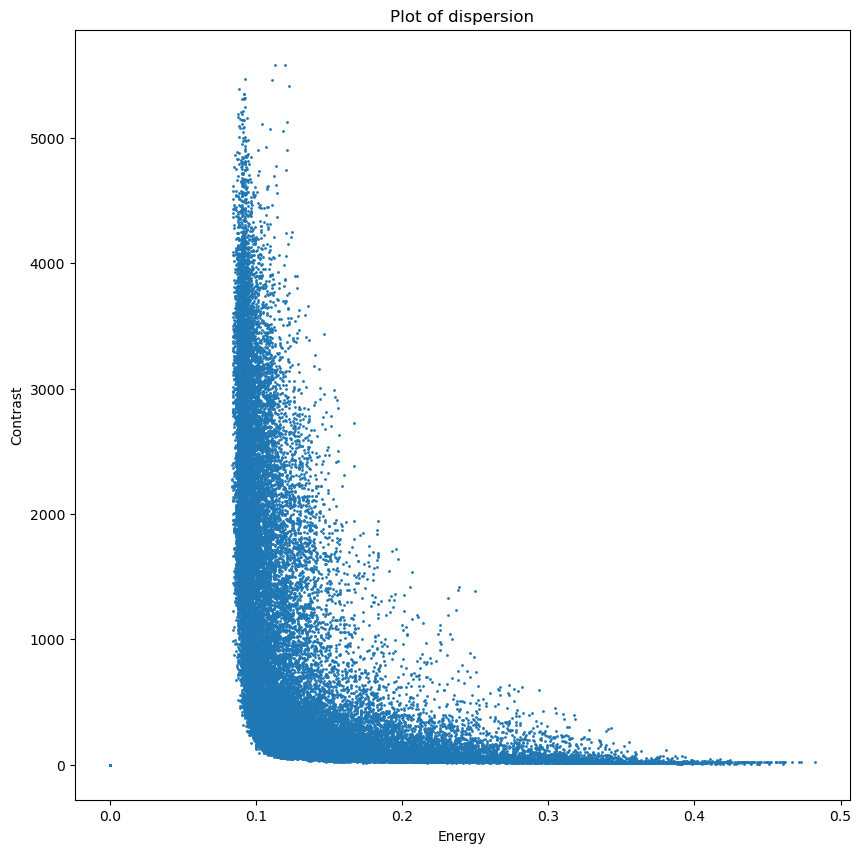

In [122]:
plt.figure(figsize= (10, 10))
plt.title('Plot of dispersion')
plt.xlabel('Energy')
plt.ylabel('Contrast')
plt.scatter(im_energy.ravel(), im_contrast.ravel(), 1)

## Texture segmentation by thresholding

In the scatter diagram, we can observe basically three types of points:

- Points with lower energy and higher contrast.
- Points with lower contrast and energy.
- Points with lower contrast and higher energy.

From the images above, we concluded that the jaguar texture is characterized by higher contrast and lower energy. We segment pixels that match the following criteria:

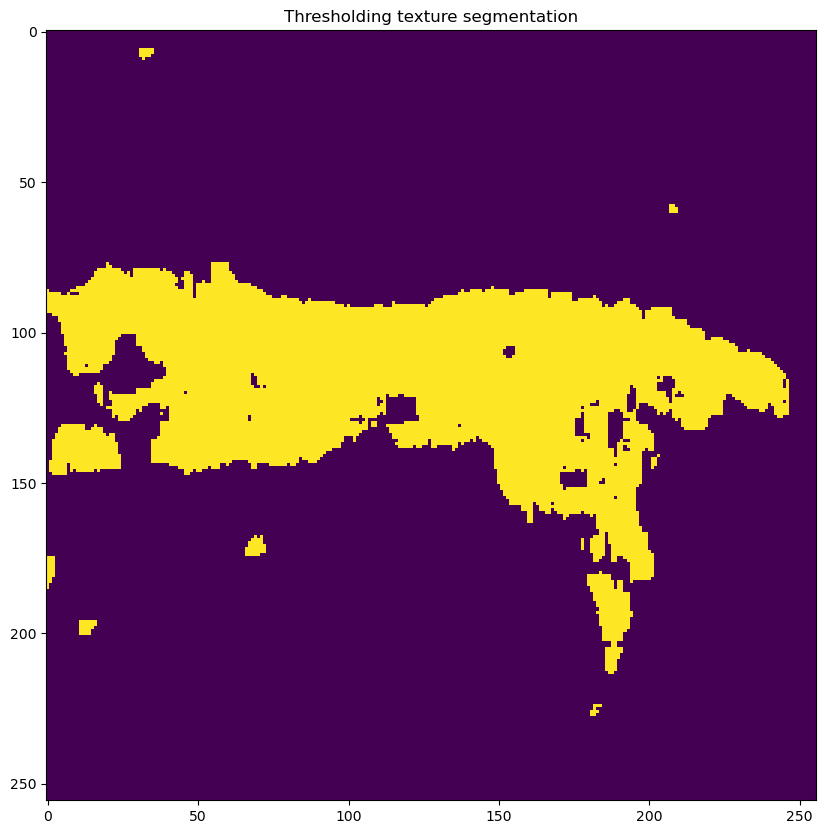

In [123]:
plt.figure(figsize= (10, 10))
plt.title('Thresholding texture segmentation')
plt.imshow(np.logical_and(im_energy < 0.15, im_contrast > 1200))

## Texture segmentation by clustering

We were able to segment the jaguar based on its specific texture. In general, however, we describe the texture with several attributes - symptoms. It would be convenient to automatically segment the image into areas with different textures. For this purpose we will now use a simple method for clustering. The goal of clustering is to divide the feature space into regions where samples with similar properties are found. We implement a simple proprietary algorithm based on the principle "winner takes all" (Winner Takes All, WTA). First, we define the set of samples and the parameters of the algorithm:

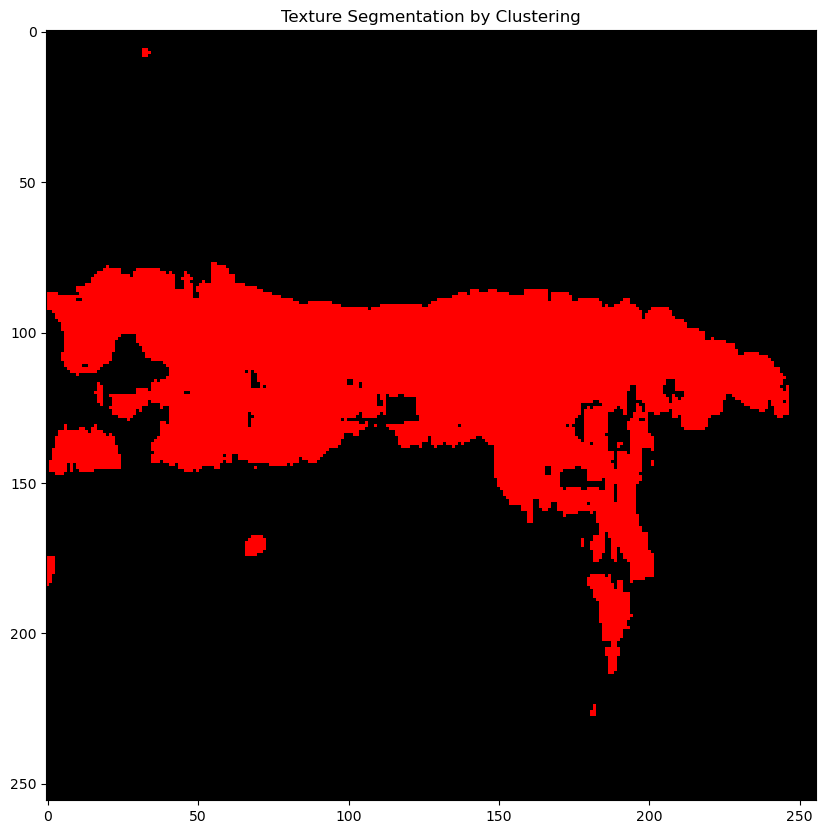

In [130]:
# Create new variables for normalized energy and contrast
normalized_energy = im_energy / np.max(im_energy)
normalized_contrast = im_contrast / np.max(im_contrast)

# Create feature vectors for clustering
energy = np.expand_dims(normalized_energy, axis=2)
contrast = np.expand_dims(normalized_contrast, axis=2)
X = np.concatenate((energy, contrast), axis=2)

# Define clustering parameters
n_iter = 5
n_centers = 2
alfa = 0.07

# Initialize random cluster centers
centers = np.random.rand(n_centers, X.shape[2])

# Perform clustering using the Winner Takes All (WTA) algorithm
for i in range(n_iter):
    for x in np.random.permutation(X.shape[0]):
        for y in np.random.permutation(X.shape[1]):
            item = X[x, y]
            distances = centers - np.tile(item, (n_centers, 1))
            distances = np.sum((distances ** 2), axis=1)
            min_distance = np.min(distances)
            indx = np.where(distances == min_distance)
            centers[indx] = (item - centers[indx]) * alfa + centers[indx]

# Create the segmentation output based on cluster indices
output = np.zeros(im_contrast.shape)
for x in range(X.shape[0]):
    for y in range(X.shape[1]):
        item = X[x, y]
        distances = centers - np.tile(item, (n_centers, 1))
        distances = np.sum((distances ** 2), axis=1)
        min_distance = np.min(distances)
        indx = np.where(distances == min_distance)
        output[x, y] = indx[0]

# Visualize the segmented image
plt.figure(figsize=(10, 10))
plt.title('Texture Segmentation by Clustering')
RGB_label = label2rgb(output)
plt.imshow(RGB_label)


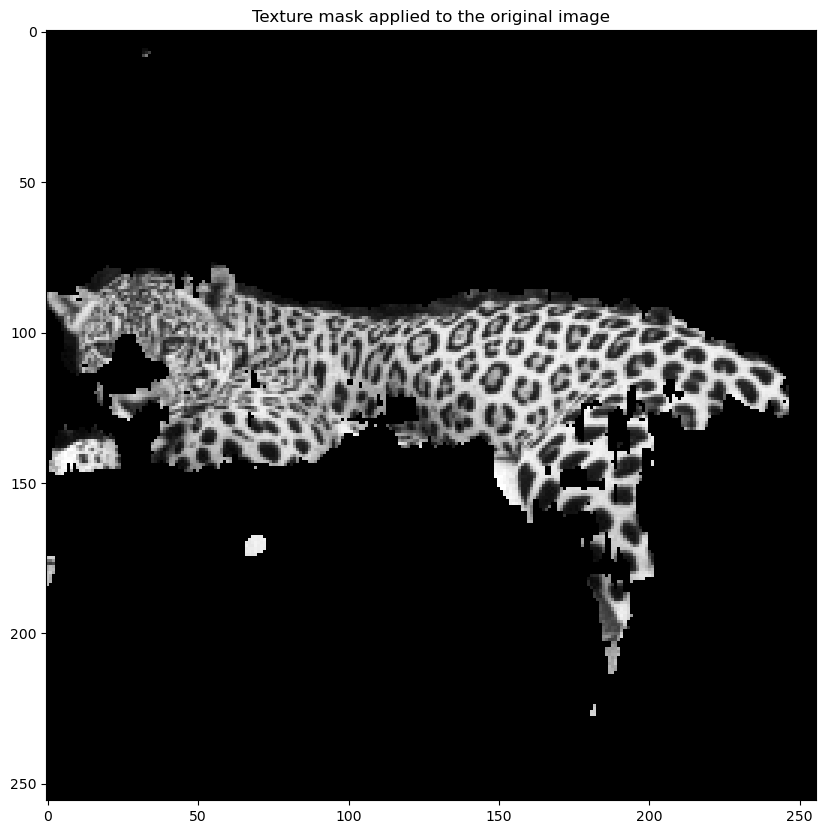

In [131]:
plt.figure(figsize= (10, 10))
plt.title('Texture mask applied to the original image')

# explain later :)
# chnl = RGB_label[:, :, 2]
# out = filters.threshold_otsu(chnl)
# mask = chnl < out
# finalMask = morphology.remove_small_holes(morphology.dilation(morphology.opening(RGB_label[:,:,1], morphology.disk(2)), morphology.disk(1)), 256)
# finalMask = morphology.remove_small_objects(finalMask, min_size= 100)

jaguar = img * RGB_label[:, :, 0]
plt.imshow(jaguar, cmap= 'gray')

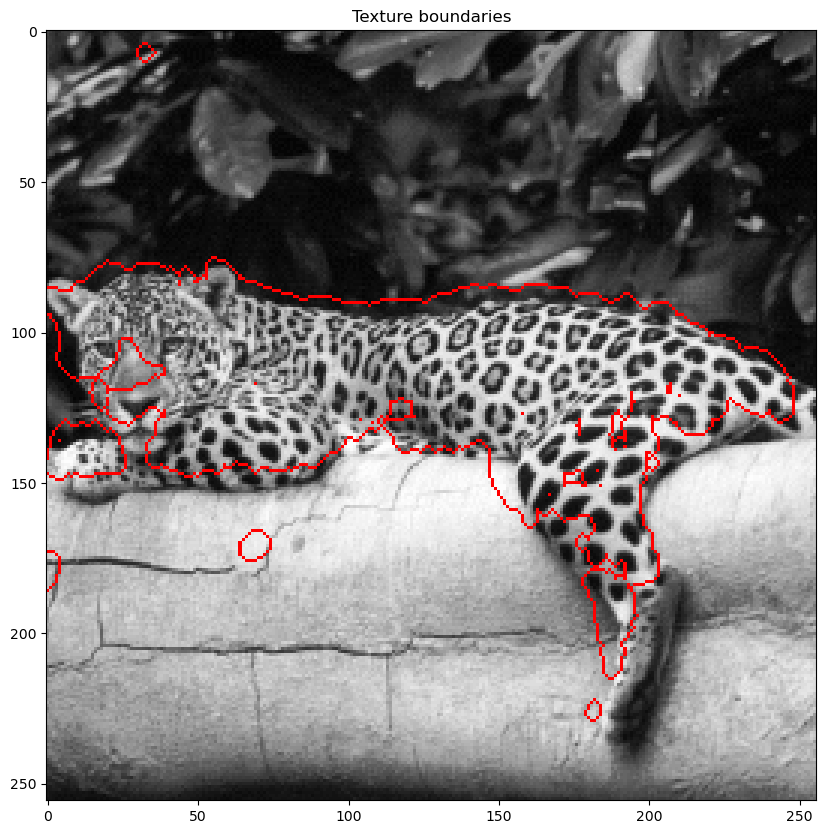

In [132]:
plt.figure(figsize= (10, 10))
plt.title("Texture boundaries")
boundary = find_boundaries(jaguar)
M_boundary = mark_boundaries(img, boundary, color= (1, 0, 0))
plt.imshow(M_boundary)